## Overview of Rapids library like cuML, cuDF, Dask 

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Mon_Oct_24_19:12:58_PDT_2022
Cuda compilation tools, release 12.0, V12.0.76
Build cuda_12.0.r12.0/compiler.31968024_0


In [49]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pynvml
pynvml.nvmlInit()

In [4]:
pynvml.nvmlDeviceGetMemoryInfo(pynvml.nvmlDeviceGetHandleByIndex(0)).total / 1024 ** 3

11.994140625

In [16]:
gpu_mem = round(pynvml.nvmlDeviceGetMemoryInfo(pynvml.nvmlDeviceGetHandleByIndex(0)).total / 1024 ** 3)

In [5]:
import pandas as pd

df = pd.DataFrame()

df['key'] = [7,5,2,6,8]
df['val'] = [float(x + 10) for x in df['key']]

In [6]:
df

,key,val
0,7,17.0
1,5,15.0
2,2,12.0
3,6,16.0
4,8,18.0


In [7]:
#aggregate
df_sum = df.val.sum()
df_sum

78.0

In [12]:
import cudf as cd

cdf = cd.DataFrame()
cdf['ind'] = [6,2,3,1,5,8]
cdf['ex'] = [float(x * 6.5) for x in cdf['ind'].values_host] #will throw error if used directly
cdf

,ind,ex
0,6,39.0
1,2,13.0
2,3,19.5
3,1,6.5
4,5,32.5
5,8,52.0


In [13]:
cdf.ex.sum()

162.5

In [15]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

%matplotlib inline

In [17]:
import numpy as np; print('NumPy Version:', np.__version__)


# create the relationship: y = 2.0 * x + 1.0
if(gpu_mem <= 16):
    n_rows = 20000 # let's use 35 thousand data points.  Very small GPU memory sizes will require you to reduce this number further 
elif(gpu_mem > 17):
    n_rows = 100000 # let's use 100 thousand data points

w = 2.0

x = np.random.normal(loc=0, scale=1, size=(n_rows,))

b = 1.0

y = w * x + b

# add a bit of noise
noise = np.random.normal(loc=0, scale=2, size=(n_rows,))
y_noisy = y + noise

NumPy Version: 1.24.4


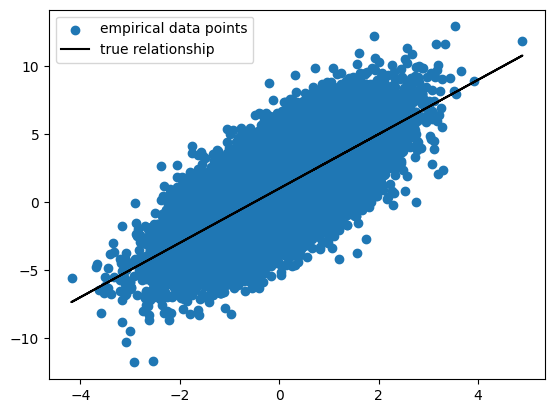

In [18]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.legend()

In [20]:
import sklearn; print('Scikit-Learn Version:', sklearn.__version__)
from sklearn.linear_model import LinearRegression


# instantiate and fit model
linear_regression = LinearRegression()

Scikit-Learn Version: 1.3.0


In [21]:
%%time

linear_regression.fit(np.expand_dims(x, 1), y)

CPU times: user 7.88 ms, sys: 0 ns, total: 7.88 ms
Wall time: 6.57 ms


LinearRegression()

In [23]:
# create a cuDF DataFrame
df = cd.DataFrame({'x': x, 'y': y_noisy})
print(df.head())

          x         y
0  0.717535  3.639953
1  0.794146  7.093883
2  0.098002  2.644101
3  1.179962  3.117574
4  0.296484  1.631518


In [24]:
from cuml.linear_model import LinearRegression as LinearRegression_GPU


# instantiate and fit model
linear_regression_gpu = LinearRegression_GPU()

/home/kamal/gitfolders/one-click-installers/installer_files/conda/envs/rapids-23.08/lib/python3.10/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


In [30]:
%%time

linear_regression_gpu.fit(df[['x']], df['y'])

CPU times: user 3.53 ms, sys: 819 µs, total: 4.35 ms
Wall time: 4.43 ms


LinearRegression()

In [31]:
import dask; print('Dask Version:', dask.__version__)
from dask.distributed import Client, LocalCluster


# create a local cluster with 4 workers
n_workers = 4
cluster = LocalCluster(n_workers=n_workers)
client = Client(cluster)

Dask Version: 2023.7.1


In [32]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 20,Total memory: 31.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43855,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.20 GiB
Comm: tcp://127.0.0.1:35167,Total threads: 5
Dashboard: http://127.0.0.1:45023/status,Memory: 7.80 GiB
Nanny: tcp://127.0.0.1:40031,


In [33]:
import time


def sleep_1():
    time.sleep(1)
    return 'Success!'

In [34]:
%%time

for _ in range(n_workers):
    sleep_1()

CPU times: user 211 ms, sys: 98 ms, total: 309 ms
Wall time: 4 s


In [35]:
from dask.delayed import delayed

In [36]:
%%time

# define delayed execution graph
sleep_operations = [delayed(sleep_1)() for _ in range(n_workers)]

# use client to perform computations using execution graph
sleep_futures = client.compute(sleep_operations, optimize_graph=False, fifo_timeout="0ms")

# collect and print results
sleep_results = client.gather(sleep_futures)
print(sleep_results)

['Success!', 'Success!', 'Success!', 'Success!']
CPU times: user 66.3 ms, sys: 36.3 ms, total: 103 ms
Wall time: 1.03 s


In [40]:
from dask.distributed import Client
# import dask_cuda; print('Dask CUDA Version:', dask_cuda.__version__)
from dask_cuda import LocalCUDACluster


# create a local CUDA cluster
cluster = LocalCUDACluster(n_workers=1)
client = Client(cluster)

/home/kamal/gitfolders/one-click-installers/installer_files/conda/envs/rapids-23.08/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46359 instead
  warnings.warn(


In [41]:
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:46359/status,
Dashboard: http://127.0.0.1:46359/status,Workers: 1
Total threads: 1,Total memory: 31.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40921,Workers: 1
Dashboard: http://127.0.0.1:46359/status,Total threads: 1
Started: Just now,Total memory: 31.20 GiB
Comm: tcp://127.0.0.1:41605,Total threads: 1
Dashboard: http://127.0.0.1:43113/status,Memory: 31.20 GiB
Nanny: tcp://127.0.0.1:36997,


In [42]:
# identify number of workers
workers = client.has_what().keys()
n_workers = len(workers)

In [43]:
workers

dict_keys(['tcp://127.0.0.1:41605'])

In [45]:
# create a cuDF DataFrame with two columns named "key" and "value"
df = cd.DataFrame()
n_rows = 100000000  # let's process 100 million rows in a distributed parallel fashion
df['key'] = np.random.binomial(1, 0.2, size=(n_rows))
df['value'] = np.random.normal(size=(n_rows))

In [47]:
import dask_cudf
# create a distributed cuDF DataFrame using Dask
distributed_df = dask_cudf.from_cudf(df, npartitions=n_workers)

../../thread/thread_load.cuh(36): warning: cuda.h: [jitify] File not found
../../thread/thread_store.cuh(36): warning: cuda.h: [jitify] File not found


In [48]:
# inspect our distributed cuDF DataFrame using Dask
print('-' * 15)
print('Type of our Dask cuDF DataFrame:', type(distributed_df))
print('-' * 15)
print(distributed_df.head())

---------------
Type of our Dask cuDF DataFrame: <class 'dask_cudf.core.DataFrame'>
---------------


/home/kamal/gitfolders/one-click-installers/installer_files/conda/envs/rapids-23.08/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 1.49 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


   key     value
0    0  0.111640
1    1  0.712618
2    0 -1.781317
3    0  2.163794
4    0  0.489024


In [50]:
aggregation = distributed_df['value'].sum()
print(aggregation.compute())

589.4565112669115


## Diving into cuDF

In [51]:
import cudf as cd

cols = cd.Series([8,5,2,6,3,9])
cols #printing it is not making much difference

0    8
1    5
2    2
3    6
4    3
5    9
dtype: int64

In [54]:
df = cd.DataFrame()
print(df) #just trying to get output will give a blank 

Empty DataFrame
Columns: []
Index: []


In [56]:
from datetime import datetime, timedelta

ids = np.arange(5)
t0 = datetime.strptime('2022-07-09 15:00:57', '%Y-%m-%d %H:%M:%S')
t0

datetime.datetime(2022, 7, 9, 15, 0, 57)

In [59]:
tstamp = [(t0 + timedelta(seconds = x + 6)) for x in range(5)]
tstmp_np = np.array(tstamp,dtype='datetime64')

In [60]:
tstmp_np

array(['2022-07-09T15:01:03.000000', '2022-07-09T15:01:04.000000',
       '2022-07-09T15:01:05.000000', '2022-07-09T15:01:06.000000',
       '2022-07-09T15:01:07.000000'], dtype='datetime64[us]')

In [61]:
df['ids'] = ids
df['stamps'] = tstmp_np

In [62]:
df

,ids,stamps
0,0,2022-07-09 15:01:03
1,1,2022-07-09 15:01:04
2,2,2022-07-09 15:01:05
3,3,2022-07-09 15:01:06
4,4,2022-07-09 15:01:07


In [64]:
import pandas as pd

pandas_df = pd.DataFrame({'a': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'b': [0.0, 0.1, 0.2, None, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]})

In [66]:
cdf = cd.from_pandas(pandas_df)
cdf.head(2)

,a,b
0,0,0.0
1,1,0.1


In [67]:
cl1 = cd.Series([1,5,7,9])
cl2 = cd.Series([2,6,8,4])
cl3 = cd.Series([11,12,13,15])
nwdf = cd.DataFrame({'col1':cl1,'col2':cl2,'col3':cl3})
nwdf

,col1,col2,col3
0,1,2,11
1,5,6,12
2,7,8,13
3,9,4,15


In [69]:
df = cd.DataFrame({'a': np.arange(0, 100), 
                     'b': np.arange(100, 0, -1)})

In [70]:
df.dtypes

a    int64
b    int64
dtype: object

In [74]:
df['c'] = df['b'].astype(np.float32)
df['d'] = df['a'].astype(np.int32)

In [76]:
df.dtypes

a      int64
b      int64
c    float32
d      int32
dtype: object

In [77]:
df.index

RangeIndex(start=0, stop=100, step=1)

In [78]:
#converting to np arrays
df.to_pandas().values

array([[  0., 100., 100.,   0.],
       [  1.,  99.,  99.,   1.],
       [  2.,  98.,  98.,   2.],
       [  3.,  97.,  97.,   3.],
       [  4.,  96.,  96.,   4.],
       [  5.,  95.,  95.,   5.],
       [  6.,  94.,  94.,   6.],
       [  7.,  93.,  93.,   7.],
       [  8.,  92.,  92.,   8.],
       [  9.,  91.,  91.,   9.],
       [ 10.,  90.,  90.,  10.],
       [ 11.,  89.,  89.,  11.],
       [ 12.,  88.,  88.,  12.],
       [ 13.,  87.,  87.,  13.],
       [ 14.,  86.,  86.,  14.],
       [ 15.,  85.,  85.,  15.],
       [ 16.,  84.,  84.,  16.],
       [ 17.,  83.,  83.,  17.],
       [ 18.,  82.,  82.,  18.],
       [ 19.,  81.,  81.,  19.],
       [ 20.,  80.,  80.,  20.],
       [ 21.,  79.,  79.,  21.],
       [ 22.,  78.,  78.,  22.],
       [ 23.,  77.,  77.,  23.],
       [ 24.,  76.,  76.,  24.],
       [ 25.,  75.,  75.,  25.],
       [ 26.,  74.,  74.,  26.],
       [ 27.,  73.,  73.,  27.],
       [ 28.,  72.,  72.,  28.],
       [ 29.,  71.,  71.,  29.],
       [ 3

In [79]:
df.to_csv('./dataset.csv', index=False)

In [81]:
df = cd.DataFrame({'a': np.arange(0, 100).astype(np.float32), 
                     'b': np.arange(100, 0, -1).astype(np.float32), 
                     'c': np.arange(100, 200).astype(np.float32)})

In [83]:
df['d'] = np.arange(200, 300).astype(np.float32)

print(df.head(2))

     a      b      c      d
0  0.0  100.0  100.0  200.0
1  1.0   99.0  101.0  201.0


In [84]:
newdf = df.drop(['a'],axis=1)
print(newdf.head())

       b      c      d
0  100.0  100.0  200.0
1   99.0  101.0  201.0
2   98.0  102.0  202.0
3   97.0  103.0  203.0
4   96.0  104.0  204.0


In [85]:
#Working on missing data
df = cd.DataFrame({'a': [0, None, 2, 3, 4, 5, 6, 7, 8, None, 10],
                     'b': [0.0, 0.1, 0.2, None, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                     'c': [0.0, 0.1, None, None, 0.4, 0.5, None, 0.7, 0.8, 0.9, 1.0]})
print(df)

       a     b     c
0      0   0.0   0.0
1   <NA>   0.1   0.1
2      2   0.2  <NA>
3      3  <NA>  <NA>
4      4   0.4   0.4
5      5   0.5   0.5
6      6   0.6  <NA>
7      7   0.7   0.7
8      8   0.8   0.8
9   <NA>   0.9   0.9
10    10   1.0   1.0


In [87]:
#fillna and replace are working the same as pandas
df.fillna(-1,inplace=True)

In [88]:
mask = df['a'] < 5
df[mask]

,a,b,c
0,0,0.0,0.0
1,-1,0.1,0.1
2,2,0.2,-1.0
3,3,-1.0,-1.0
4,4,0.4,0.4
9,-1,0.9,0.9


In [90]:
#Ascending false is descending
df.sort_values('c',ascending=False)

,a,b,c
10,10,1.0,1.0
9,-1,0.9,0.9
8,8,0.8,0.8
7,7,0.7,0.7
5,5,0.5,0.5
4,4,0.4,0.4
1,-1,0.1,0.1
0,0,0.0,0.0
2,2,0.2,-1.0
3,3,-1.0,-1.0


In [92]:
df = cd.DataFrame({'a': np.repeat([0, 1, 2, 3], 25).astype(np.int32), 
                     'b': np.random.randint(2, size=100).astype(np.int32), 
                     'c': np.arange(0, 100).astype(np.int32), 
                     'd': np.arange(100, 0, -1).astype(np.int32)})

In [93]:
df.sum()

a     150
b      40
c    4950
d    5050
dtype: int64

In [94]:
def add_ten(x):
    return x + 5

In [95]:
df['cg'] = df['c'].apply(add_ten)

In [97]:
df.head(2)

,a,b,c,d,cg
0,0,0,0,100,5
1,0,0,1,99,6


In [103]:
df1 = cd.DataFrame({'a': np.repeat([0, 1, 2, 3], 25).astype(np.int32), 
                      'b': np.random.randint(2, size=100).astype(np.int32), 
                      'c': np.arange(0, 100).astype(np.int32), 
                      'd': np.arange(100, 0, -1).astype(np.int32)})
df2 = cd.DataFrame({'e': np.repeat([0, 1, 2, 3], 25).astype(np.int32), 
                      'f': np.random.randint(2, size=100).astype(np.int32), 
                      'i': np.arange(0, 100).astype(np.int32), 
                      't': np.arange(100, 0, -1).astype(np.int32)})
#The col names have to be different

In [101]:
condf = cd.concat([df1,df2],axis=0)
print(condf.head(5))
condf.shape

   a  b  c    d
0  0  1  0  100
1  0  1  1   99
2  0  0  2   98
3  0  0  3   97
4  0  1  4   96


(200, 4)

In [105]:
cond_col = cd.concat([df1,df2],axis=1)
print(cond_col.head(5))
#name of teh cols have to be different
cond_col.shape

   a  b  c    d  e  f  i    t
0  0  0  0  100  0  1  0  100
1  0  1  1   99  0  1  1   99
2  0  1  2   98  0  0  2   98
3  0  1  3   97  0  1  3   97
4  0  0  4   96  0  0  4   96


(100, 8)

In [107]:
df1 = cd.DataFrame({'a': np.repeat([0, 1, 2, 3], 25).astype(np.int32), 
                      'b': np.random.randint(2, size=100).astype(np.int32), 
                      'c': np.arange(0, 100).astype(np.int32), 
                      'd': np.arange(100, 0, -1).astype(np.int32)})

df2 = cd.DataFrame({'a': np.repeat([0, 1, 2, 3], 25).astype(np.int32), 
                      'b': np.random.randint(2, size=100).astype(np.int32), 
                      'e': np.arange(0, 100).astype(np.int32), 
                      'f': np.arange(100, 0, -1).astype(np.int32)})

In [108]:
df = df1.merge(df2)
print(df.head())

   a  b   c   d   e   f
0  1  1  32  68  32  68
1  1  1  32  68  37  63
2  1  1  32  68  33  67
3  1  1  32  68  38  62
4  1  0  33  67  34  66


In [109]:
df = df1.merge(df2, on=['a'])
print(df.head())

   a  b_x  c    d  b_y  e    f
0  0    0  0  100    0  0  100
1  0    0  0  100    0  2   98
2  0    0  0  100    0  1   99
3  0    0  0  100    0  3   97
4  0    1  1   99    0  0  100


In [110]:
grp_df = df.groupby('a')
grp_df

In [111]:
grp_df.sum()

,b_x,c,d,b_y,e,f
a,,,,,,
3,225,54375,8125,250,54375,8125
1,300,23125,39375,375,23125,39375
2,275,38750,23750,300,38750,23750
0,250,7500,55000,275,7500,55000


In [113]:
df.groupby(['a','c']).sum().to_pandas()

,,b_x,d,b_y,e,f
a,c,,,,,
2,50,25,1250,12,1550,950
1,43,0,1425,15,925,1575
0,2,0,2450,11,300,2200
3,88,0,300,10,2175,325
2,73,25,675,12,1550,950
...,...,...,...,...,...,...
1,29,0,1775,15,925,1575
3,77,0,575,10,2175,325
1,33,0,1675,15,925,1575


In [118]:
result = cd.get_dummies(df, 
                          columns='e', 
                          prefix='e_', 
                          cats=[1,2,5,6])
print(result.head())
print(result.tail())

   a  b_x  c    d  b_y    f  ...  e__94  e__95  e__96  e__97  e__98  e__99
0  0    0  0  100    0  100  ...      0      0      0      0      0      0
1  0    0  0  100    0   98  ...      0      0      0      0      0      0
2  0    0  0  100    0   99  ...      0      0      0      0      0      0
3  0    0  0  100    0   97  ...      0      0      0      0      0      0
4  0    1  1   99    0  100  ...      0      0      0      0      0      0

[5 rows x 106 columns]
      a  b_x   c   d  b_y   f  ...  e__94  e__95  e__96  e__97  e__98  e__99
2495  1    1  49  51    0  71  ...      0      0      0      0      0      0
2496  1    1  49  51    1  72  ...      0      0      0      0      0      0
2497  1    1  49  51    1  70  ...      0      0      0      0      0      0
2498  1    0  48  52    1  69  ...      0      0      0      0      0      0
2499  1    1  49  51    1  69  ...      0      0      0      0      0      0

[5 rows x 106 columns]
